In [1]:
import numpy as np
from scipy import linalg
%matplotlib notebook

import matplotlib.pyplot as plt

In [80]:
d=2 # Dimension. For spin 1/2 the dimention = 2
J=1. # XX interaction coefficient
gz=0.25 # Z field strength
gx=0.2 # X field strength
N=16 # Total number of spins
delta =0.02 # Time step
chi=20 # Maximum number of singular values

sx=np.array([[0.,1.],[1.,0.]])
sz=np.array([[1.,0.],[0.,-1.]])
h_int=J*np.kron(sx,sx)
h_single=gz*sz+gx*sx
U_int=linalg.expm(1j*h_int*delta).reshape(d,d,d,d) # U(si,s(i+1),si',s(i+1)')
U_z=linalg.expm(1j*h_single*delta).reshape(d,d) # U(si,si')

rho0i=np.array([np.sqrt(0.5),np.sqrt(0.5)]).reshape(2,1,1)
rho0=list()
for i in range(0,N):
    rho0.append(rho0i)

Mz=list()
Mz.append(np.transpose(np.array([[sz,np.eye(2)]]),(2,3,0,1)))
for i in range(1,N-1):
    temp1=np.array([[np.eye(2),np.zeros((2,2))],[sz,np.eye(2)]])
    temp=np.transpose(temp1,(2,3,0,1))
    Mz.append(temp)
Mz.append(np.transpose(np.array([[np.eye(2)],[sz]]),(2,3,0,1))) # Mz(i,si,si',ai,bi)

Mx=list()
Mx.append(np.transpose(np.array([[sx,np.eye(2)]]),(2,3,0,1)))
for i in range(1,N-1):
    temp1=np.array([[np.eye(2),np.zeros((2,2))],[sx,np.eye(2)]])
    temp=np.transpose(temp1,(2,3,0,1))
    Mx.append(temp)
Mx.append(np.transpose(np.array([[np.eye(2)],[sx]]),(2,3,0,1))) # Mz(i,si,si',ai,bi)

def exp(o,rho):
    L=len(o)
    temp=np.tensordot(o[0],rho[0],axes=([1,0])) # temp(osi,oai,obi,rhoai,rhobi)
    temp=np.tensordot(np.conj(rho[0]),temp,axes=([0,0])) # temp(rhoai',rhobi',oai,obi,rhoai,rhobi) 'belongs to conj.
    temp=np.transpose(temp,(0,2,4,1,3,5)) # temp(rhoai',oai,rhoai,rhobi',obi,rhobi)
    for i in range(1,L):
        temp1=np.tensordot(o[i],rho[i],axes=([1,0]))
        temp1=np.tensordot(np.conj(rho[i]),temp1,axes=([0,0])) # temp(rhoai',rhobi',oai,obi,rhoai,rhobi)
        temp=np.tensordot(temp,temp1,axes=([3,4,5],[0,2,4]))
    return temp[0,0,0,0,0,0]

def uni(rho):
    L=len(rho)
    temp=rho[0]
    for i in range(1,L):
        temp=np.tensordot(temp,rho[i],axes=([len(np.shape(temp))-1,1]))
    return temp

# returns <rho|rho>
def norm(rho):
    L=len(rho)
    temp=np.tensordot(np.conj(rho[0]),rho[0],axes=([0,0])) # temp(a0',b0',a0,b0) 'belongs to conj.
    temp=np.transpose(temp,(0,2,1,3)) # temp(a0',a0,b0',b0)
    for i in range(1,L):
        temp1=np.tensordot(np.conj(rho[i]),rho[i],axes=([0,0])) # temp1(ai',bi',ai,bi)
        temp=np.tensordot(temp,temp1,axes=([2,3],[0,2])) # temp(a0',a0,bi',bi)
    return abs(temp[0,0,0,0])

# two-site evolution
def evo2(A1,A2,U,chi):
    theta=np.tensordot(A1,A2,axes=([2,1])) # theta(si,ai,s(i+1),b(i+1))
    dai=A1.shape[1] # dimension of ai
    dbip1=A2.shape[2] # dimension of b(i+1)
    # apply U 
    theta=np.tensordot(U,theta,axes=([2,3],[0,2])) # theta(si,s(i+1),ai,b(i+1))
    theta=np.transpose(theta,(0,2,1,3)) # theta(si,ai,s(i+1),b(i+1))
    sh=theta.shape
    theta=theta.reshape(sh[0]*sh[1],sh[2]*sh[3])
    [L,S,R]=np.linalg.svd(theta)
    ent=S.shape[0];
    for i in range(1,S.shape[0]):
        if S[i]<1e-5*S[0]:
            ent=i
            break
    if ent<chi:
        D=np.diag(np.sqrt(S[0:ent]))
    else:
        ent=chi
        D=np.diag(np.sqrt(S[0:ent]))
    L=L[:,0:ent] # L(si*ai,bi)
    R=R[0:ent,:] # R(a(i+1),s(i+1)*b(i+1))
    R=np.dot(D,R)
    L=np.dot(L,D)
    B1=L.reshape(d,dai,ent)
    B2=np.transpose(R.reshape(ent,d,dbip1),(1,0,2))
    return B1,B2

#single-site evolution
def evo1(A,U):
    # A(si,ai,bi)
    # U(si,si')
    A=np.tensordot(U,A,axes=([1,0])) # A(si,ai,bi)
    return A

def hcee(rho):
    L=len(rho)
    [l,S,r]=np.linalg.svd(uni(rho).reshape(int(2**(L/2)),int(2**(L/2))))
    ee=0;
    for p in range(0,len(S)):
        if S[p]>1e-10:
            ee=ee-2*(S[p]**2)*np.log(S[p])
    return ee

In [81]:
T=1000
MzExp=np.zeros(T)
MxExp=np.zeros(T)
Entropy=np.zeros(T)
#rho=list(Mx)
rho=list(rho0)
Norm=norm(rho)
for i in range(0,N):
    rho[i]=rho[i]*(1/Norm)**(0.5/N)
MzExp[0]=np.real(exp(Mz,rho))
MxExp[0]=np.real(exp(Mx,rho))
Entropy[0]=hcee(rho)

for p in range(1,T):
    if p%100==0:
        print(p)
    for i in range(0,N-1,2):
        temp1,temp2=evo2(rho[i],rho[i+1],U_int,chi)
        rho[i]=temp1
        rho[i+1]=temp2
    for i in range(1,N-1,2):
        temp1,temp2=evo2(rho[i],rho[i+1],U_int,chi)
        rho[i]=temp1
        rho[i+1]=temp2
    for i in range(0,N):
        rho[i]=evo1(rho[i],U_z)
    Norm=norm(rho)
    for i in range(0,N):
        rho[i]=rho[i]*(1/Norm)**(0.5/N)
    MzExp[p]=np.real(exp(Mz,rho))
    MxExp[p]=np.real(exp(Mx,rho))
    Entropy[p]=hcee(rho)

100
200
300
400
500
600
700
800
900


In [79]:
tlist=np.arange(0,T*delta,delta)
plt.plot(tlist,Entropy)
plt.show()

<IPython.core.display.Javascript object>


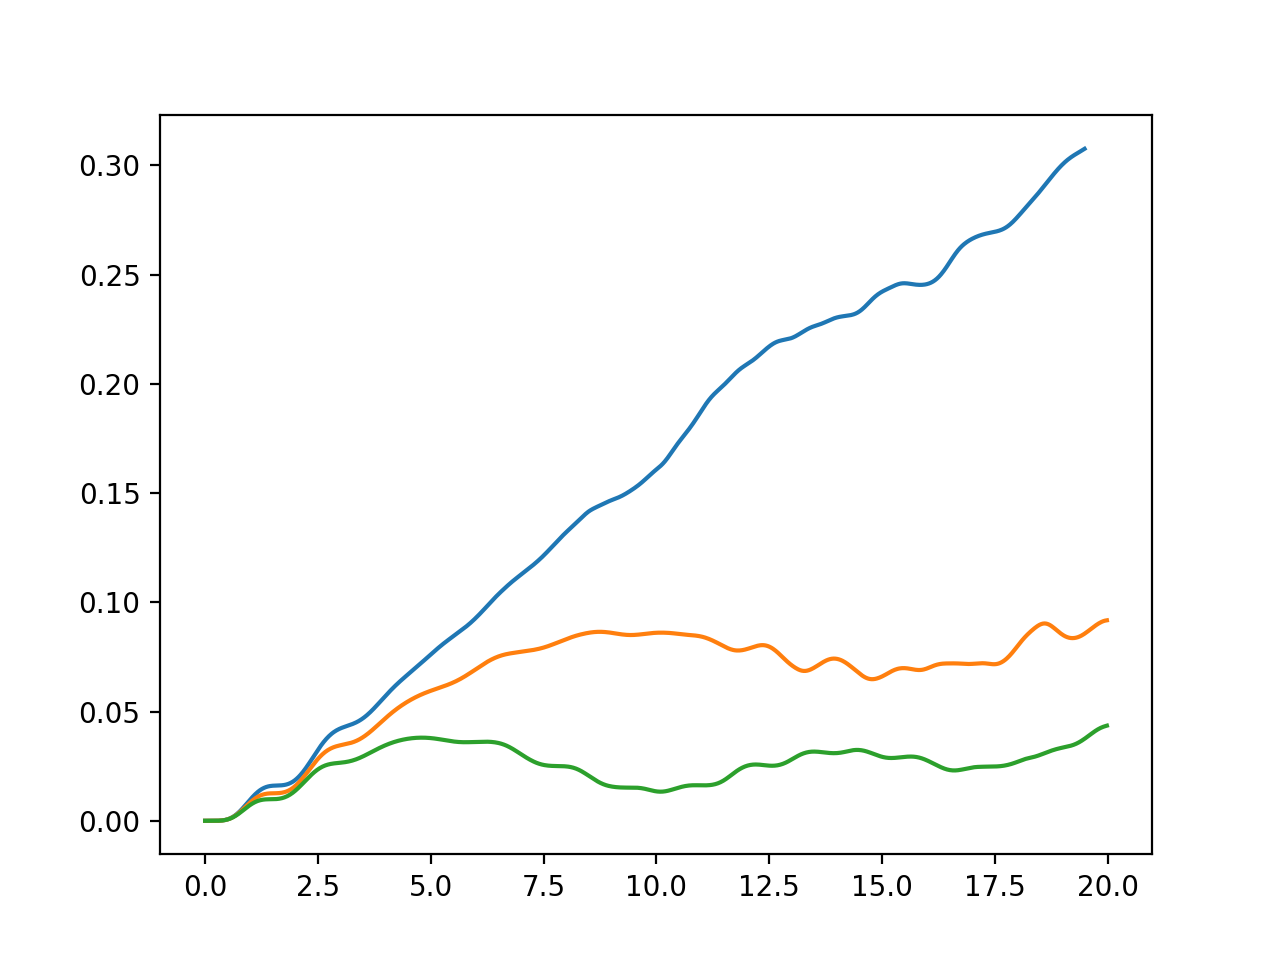

In [73]:
tlist=np.arange(0,T*delta,delta)
plt.plot(tlist,Entropy)
plt.show()

In [72]:
tlist=np.arange(0,T*delta,delta)
plt.plot(tlist,Entropy)
plt.show()

In [14]:
10%5

0